In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm3b.1_0h 04 arm3b.1_2h 05 arm3b.2_0h 06 arm3b.2_2h
1 0.9839567 23.86239     0.8665370      33.90282            NA            NA
2 1.0619138 23.20987     1.1434025      36.84338            NA            NA
3 0.9570503 23.53387     1.0092848      33.90282            NA            NA
4        NA       NA            NA            NA            NA            NA
5 0.9908006 32.37182     1.0497167      19.29293            NA            NA
6 0.8274056 44.22121     0.9138314      19.97329            NA            NA
  07 flg22_0h 08 flg22_2h   Group
1   1.1250585    73.00888 Trial01
2   0.9592641    72.00374 Trial01
3   0.9265881    71.50638 Trial01
4          NA          NA    <NA>
5   0.8705506    82.71058 Trial02
6   1.1892071    81.57188 Trial02
# A tibble: 6 × 3
  ind           Group   values
  <chr>         <chr>    <dbl>
1 01 wt_0h      Trial01  0.984
2 02 wt_2h      Trial01 23.9  
3 03 arm3b.1_0h Trial01  0.867
4 04 arm3b.1_2h Trial01 33.9  
5 05 arm3b.2_0h Tri

# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 wt_0h  Trial01  0.984
2 01 wt_0h  Trial01  1.06 
3 01 wt_0h  Trial01  0.957
4 02 wt_2h  Trial01 23.9  
5 02 wt_2h  Trial01 23.2  
6 02 wt_2h  Trial01 23.5  


[1] 71 70

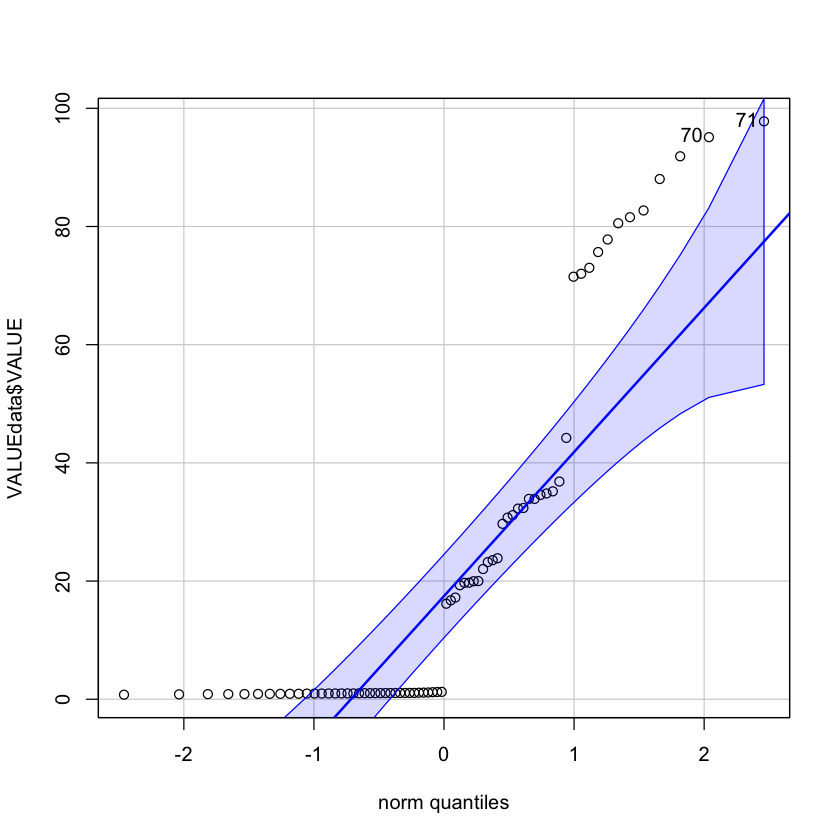

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   465.4    488.2   -222.7    445.4       62 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.91833 -0.63001 -0.05769  0.51429  3.11067 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  5.823   2.413   
 Residual             26.013   5.100   
Number of obs: 72, groups:  Trial, 4

Fixed effects:
                        Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)             1.005196   1.903538 14.983994   0.528    0.605    
Treatment02 wt_2h      26.970826   2.082182 67.984349  12.953  < 2e-16 ***
Treatment03 arm3b.1_0h  0.316083   2.626431 70.241346   0.120    0.905    
Treatment04 arm3b.1_2h 26.580800   2.626431 70.241346  10.121 2.33e-15 ***
Treatment05 arm3b.2_0h -0.311243   2.626431 70.241346  -0.119    0.9

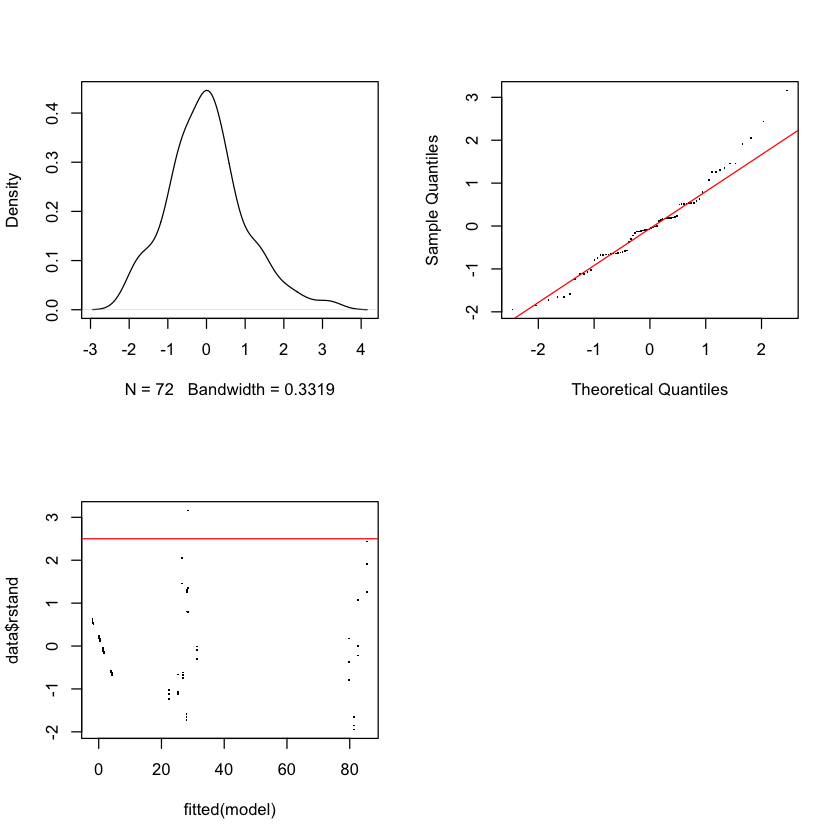

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF          F value     
 Min.   :60058   Min.   :8580   Min.   :7   Min.   :68.32   Min.   :329.8  
 1st Qu.:60058   1st Qu.:8580   1st Qu.:7   1st Qu.:68.32   1st Qu.:329.8  
 Median :60058   Median :8580   Median :7   Median :68.32   Median :329.8  
 Mean   :60058   Mean   :8580   Mean   :7   Mean   :68.32   Mean   :329.8  
 3rd Qu.:60058   3rd Qu.:8580   3rd Qu.:7   3rd Qu.:68.32   3rd Qu.:329.8  
 Max.   :60058   Max.   :8580   Max.   :7   Max.   :68.32   Max.   :329.8  
     Pr(>F)         
 Min.   :4.739e-50  
 1st Qu.:4.739e-50  
 Median :4.739e-50  
 Mean   :4.739e-50  
 3rd Qu.:4.739e-50  
 Max.   :4.739e-50  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                     Estimate Std. Error z value Pr(>|z|)    
02 wt_2h - 01 wt_0h == 0       